Relating expo survey entrance data against terrain model

In [91]:
# get the header values from both files
fin = open("als_dgm_1m.txt", "r")
headervals = dict((l[0], float(l[1].replace(",", ".")))  for l in (fin.readline().split()  for i in range(6)))
fin2 = open("ALS_DGM_1M.prj", "r")
headervals.update(dict(fin2.readline().split()  for i in range(6)))
fin.close(); fin2.close()
print(headervals)


{'ncols': 801.0, 'nrows': 1251.0, 'xllcorner': 411099.5, 'yllcorner': 5282599.5, 'cellsize': 1.0, 'NODATA_value': -9999.0, 'Projection': 'UTM', 'Zone': '33', 'Datum': 'WGS84', 'Spheroid': 'WGS84', 'Units': 'METERS', 'Zunits': 'NO'}


In [120]:
# read terrain numbers into array trimming off last row and column that are just NODATA -9999 values
import pandas, numpy
r = pandas.read_csv("als_dgm_1m.txt", decimal=',', header=None, skiprows=6, delim_whitespace=True)
r = r.iloc[:-1,:-1]
print("shape", r.shape, "height range", min(numpy.min(r)), max(numpy.max(r)))


shape (1250, 800) height range 1685.54 1939.42


In [122]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    ----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be an
        array or a PIL image. If `X` is an array, it
        can have the following shapes and types:
    
        - MxN -- values to be mapped (float or int)
        - MxNx3 -- RGB (float or uint8)
        - MxNx4 -- RGBA (float or uint8)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0. MxN arrays are mapped
        to colors based on the `norm` (mapping scalar to scalar)
        and the `cmap` (mapping the normed scalar to a color).
    
    cm

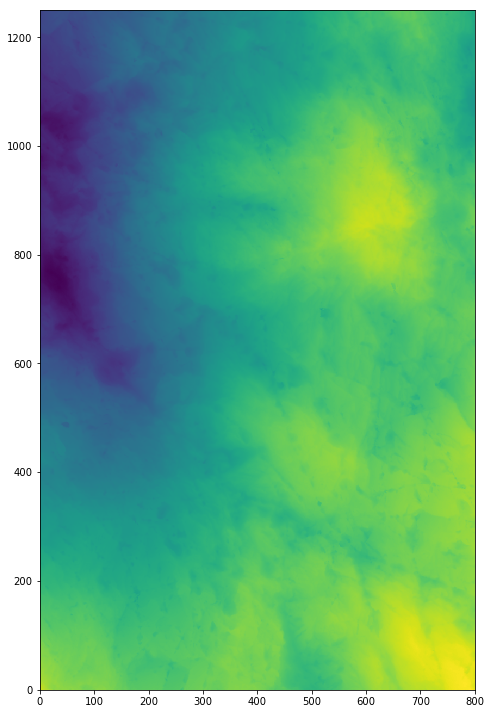

In [123]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 12.5))
plt.imshow(r, origin="lower")
#plt.plot(entx, enty, 'ro')


Quick loading tech for the 1m resolution lidar terrain we have over the plateau

We would like to save this into xcm format used by xcsoar and set prospecting projects as a hang-gliding task with a set of waypoints that have 5m radii around them and a sequence that doesn't have too many steep paths between them

xcm files are made by mapgen and are just zip files containing all the different features.  The terrain is in a jp2 image with a terrain.tfw file with the position information

Let's give a try with the following conversion found in srtm.py of mapgen

* gdal_translate -ot UInt32 -of JP2OpenJPEG -co BLOCKXSIZE=256 -co BLOCKYSIZE=256 -co QUALITY=95 als_dgm_1m.txt terrain.jp2

Putting this into the xcm file nearly works but it's coming as all one shade.  We don't know what -ot value is required



In [48]:
xllcorner, yllcorner
#Rechtswert 411100 to 411900
#Hochwert: 5283850 to 5282600


(411099.5, 5282599.5)

In [158]:
import sys
sys.path.append("/home/julian/repos/groundwindow/")
import parse3ddmp
dmp3d = parse3ddmp.DMP3d(open("all.dmp").readlines())

In [160]:
ents = [ (name, (p[0] - headervals["xllcorner"])/headervals["cellsize"], (p[1] - headervals["yllcorner"])/headervals["cellsize"], p[2])  \
         for p, name, flags in dmp3d.nodes  if "ENTRANCE" in flags ]
ents = [ (name, int(x), int(y), alt)  for name, x, y, alt  in ents  if 0<=x<=headervals["ncols"]-1 and 0<=y<=headervals["nrows"]-1 ]
ents.sort(key=lambda X:X[3])  # ascending altitude
len(ents)


109

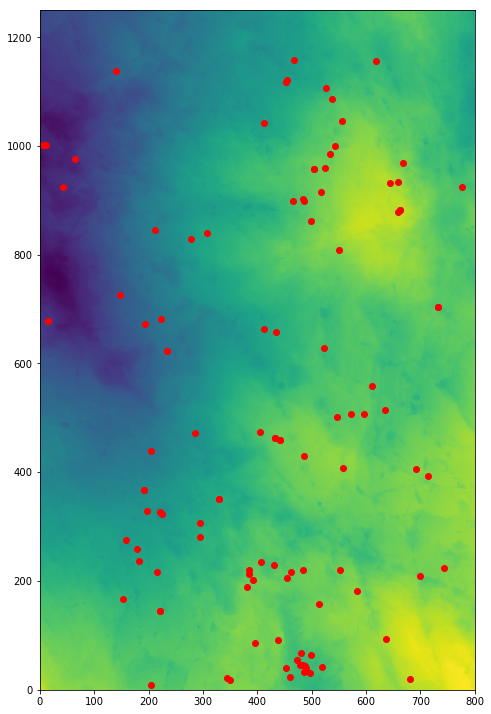

In [162]:
plt.figure(figsize=(8, 12.5))
plt.imshow(r, origin="lower")
plt.plot([e[1] for e in ents], [e[2] for e in ents], 'ro')


In [174]:
d = 2 # spread of cells we scan around the selected position
def minmaxalt(r, x, y):
    r9 = r.iloc[max(0,y-d):min(r.shape[0],y+d+1), max(0,x-d):min(r.shape[1],x+d+1)]
    return (r9.min().min(), r9.max().max())
entst = [ ] 
for name, x, y, alt in ents:
    entst.append((name, x, y, alt)+minmaxalt(r, x, y))
ents = entst
    

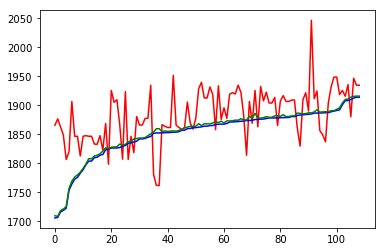

In [176]:
ents.sort(key=lambda X:X[4])  # ascending altitude
plt.plot([e[3]  for e in ents], label="ent alt", color="r")
plt.plot([e[4]  for e in ents], label="terrainlo", color="b")
plt.plot([e[5]  for e in ents], label="terrainlohi", color="g")

